In [1]:
import json
import pickle
import random
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from indra import belief
from indra.belief.skl import CountsScorer
from indra.ontology.bio import bio_ontology
from indra.preassembler import Preassembler
from indra.tools import assemble_corpus as ac
from indra.statements import Phosphorylation, Modification, stmts_from_json, stmts_to_json

## Train the belief model on previously curated statements

Load the curated statements from JSON file:

In [2]:
with open('../data/protmapper_belief_training_corpus.json', 'r') as f:
    stmt_json = json.load(f)
    training_stmts = stmts_from_json(stmt_json)

In [3]:
with open('../data/protmapper_belief_training_corpus_curations.json', 'r') as f:
    curations_by_hash = json.load(f)
    # Convert hashes from strings to int after JSON deserialization
    curations_by_hash = {int(k): v for k, v in curations_by_hash.items()}

In [4]:
# Match the correctness values to the statements by hash
correctness_arr = [curations_by_hash[s.get_hash()] for s in training_stmts]

In [5]:
# The best performing Belief model makes use of evidence directly supporting
# a particular statement and the evidence from more specific statements.
with open('../data/protmapper_belief_training_corpus_extra_evidences.pkl', 'rb') as f:
    extra_evidence = pickle.load(f)

In [7]:
# Get list of sources found in the training statement evidences
all_sources = list(set([ev.source_api for stmt in training_stmts for ev in stmt.evidence]))
all_sources

['sparser',
 'signor',
 'bel',
 'isi',
 'trips',
 'hprd',
 'medscan',
 'trrust',
 'reach',
 'biopax',
 'rlimsp']

In [8]:
# Use a Random Forest classifier
clf = RandomForestClassifier(n_estimators=2000, max_depth=13)

# Provide all available features as well as the more specific evidences.
# However, limit the source evidence to only what is obtained from readers
scorer = CountsScorer(
    clf, all_sources, use_stmt_type=True, use_num_pmids=True,
    use_promoter=True, use_avg_evidence_len=True, include_more_specific=True,
    use_residue_position=True)

# Train the model on the curated data
scorer.fit(training_stmts, correctness_arr, extra_evidence)

## Load and preprocess ProtMapper corpus statements

In [10]:
protmap_stmts = ac.load_statements('../data/annotation_statements_2.pkl')

INFO: [2022-10-26 11:48:16] indra.tools.assemble_corpus - Loading ../data/annotation_statements_2.pkl...
INFO: [2022-10-26 11:48:18] indra.tools.assemble_corpus - Loaded 37028 statements


In [11]:
dbs = set(['psp', 'signor', 'hprd', 'pid', 'bel', 'reactome'])

In [13]:
# Assign every db source_api to biopax as a proxy
for stmt in protmap_stmts:
    for ev in stmt.evidence:
        if ev.source_api in dbs:
            ev.source_api = 'biopax'

In [14]:
protmap_stmts = [s for s in protmap_stmts if s.agent_list()[0] is not None]

In [15]:
pa = Preassembler(bio_ontology, protmap_stmts)

In [16]:
protmap_stmts = pa.combine_related(return_toplevel=False)

Finding refinement relations:   0%|          | 0/36904 [00:00<?, ?it/s]INFO: [2022-10-26 11:49:11] indra.ontology.bio.ontology - Initializing INDRA bio ontology for the first time, this may take a few minutes...
INFO: [2022-10-26 11:49:11] indra.ontology.bio.ontology - Adding nodes...
INFO: [2022-10-26 11:50:02] indra.ontology.bio.ontology - Adding xrefs...


INFO: [2022-10-26 11:50:12] indra.ontology.bio.ontology - Adding hierarchy...
INFO: [2022-10-26 11:50:32] indra.ontology.bio.ontology - Adding replacements...
INFO: [2022-10-26 11:50:47] indra.ontology.bio.ontology - Building name lookup...
INFO: [2022-10-26 11:50:51] indra.ontology.bio.ontology - Finished initializing bio ontology...
INFO: [2022-10-26 11:50:51] indra.ontology.bio.ontology - Caching INDRA bio ontology at /Users/johnbachman/.indra/bio_ontology/1.28/bio_ontology.pkl
Finding refinement relations: 100%|██████████| 36904/36904 [01:57<00:00, 315.09it/s]   
INFO: [2022-10-26 11:51:08] indra.preassembler - Found 5068 refinements in 117.96s
INFO: [2022-10-26 11:51:08] indra.preassembler - Total comparisons: 109478


Split statements into those with and without support (direct or indirect) from databases:

In [19]:
with_db_ev = []
no_db_ev = []
for s in protmap_stmts:
    sources = set([e.source_api for e in s.evidence])
    for supp_stmt in s.supports:
        for supp_ev in supp_stmt.evidence:
            sources.add(supp_ev.source_api)
    if 'biopax' in sources:
        with_db_ev.append(s)
    else:
        no_db_ev.append(s)

Count statements with and without database support:

In [20]:
len(with_db_ev)

23931

In [21]:
len(no_db_ev)

12973

## Predict belief for ProtMapper statements using trained model

Assign all statements with DB support a belief of 1:

In [23]:
for stmt in with_db_ev:
    stmt.belief = 1

In [26]:
stmts = no_db_ev
belief_engine = belief.BeliefEngine(scorer)
belief_engine.set_hierarchy_probs(stmts)

Plot histogram of beliefs:

Text(0.5, 0, 'Belief')

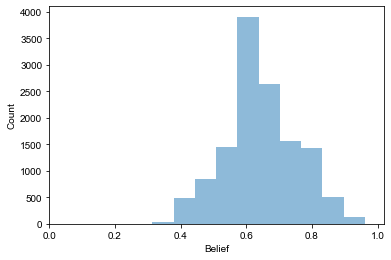

In [27]:
rf_beliefs = [s.belief for s in stmts]
hist_res = plt.hist(rf_beliefs, alpha=0.5)
#plt.hist(default_beliefs, alpha=0.5)
plt.xlim(0, 1.02)
plt.ylabel('Count')
plt.xlabel('Belief')

## Dumping the curated statements for the protmapper paper:

In [ ]:
# Load pickle of bioexp statements.
bioexp_stmts = ac.load_statements('../../bioexp_paper/data/bioexp_asmb_preassembled.pkl')

In [ ]:
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in kge_df.itertuples():
        stmt_hash = row.stmt_hash
        if stmt_hash not in stmts_by_hash:
            continue
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

stmts_by_hash = {s.get_hash(): s for s in bioexp_stmts}
# Load the curated data
curation_data_file = '../../bioexp_paper/notebooks/curation_dataset_with_bg_psp.pkl'
kge_df = load_curation_data(curation_data_file)

In [ ]:
# Get statements from curation dataframe
kge_stmts = stmts_for_df(kge_df, stmts_by_hash)
kge_hashes = [s.get_hash() for s in kge_stmts]

# Curated correctness values
y_arr = kge_df['correct'].values
y_arr = [int(val) for val in y_arr] # Convert to int for JSON serialization

In [ ]:
# Get the more specific evidences for the curated statements
extra_evidence = belief.get_ev_for_stmts_from_supports(kge_stmts)

In [ ]:
# Save the curated stmts
with open('../data/protmapper_belief_training_corpus.json', 'w') as f:
    json.dump(stmts_to_json(kge_stmts), f)
    
# Save the curations
with open('../data/protmapper_belief_training_corpus_curations.json', 'w') as f:
    json.dump(dict(zip(kge_hashes, y_arr)), f)
    
# Save the extra evidences
with open('../data/protmapper_belief_training_corpus_extra_evidences.pkl', 'wb') as f:
    pickle.dump(extra_evidence, f)